In [1]:
# import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline 

build standard Encoder-Decoder

In [2]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
    def forward(self, src, tgt, src_mask, tgt_mask):
        'take in and process masked src and target sequences'
        return self.decoder(self.encoder(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
        

define standard linear + softmax generation step 

In [3]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
    
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)
    

produce N identical layers

In [4]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [5]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        'Core encoder is a stacl of N layers'
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        'Pass the input and mask through each layer in turn'
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm()
    

employ a residual connection around each of the two sub-layers, followed by layer normalization

In [6]:
class LayerNorm(nn.Module):
    'Construct a layernorm module'
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.parameter(torch.ones(features))
        self.b_2 = nn.parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [7]:
class SublayerConnection(nn.Module):
    'A residual connection followed by a layer norm'
    'Note for code simplisity the norm is first as opposed to last'

def __init__(self, size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

def forward(self, x, sublayer):
    'Apply residual connection to any sublayer with the same size'
    return x + self.dropout(sublayer(self.norm(x)))

In [8]:
class EncoderLayer(nn.Module):
    'Encoder is made up of self-attn and feed forward'
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
    
    def forward(self, x, mask):
        'Follow Figure 1 for connections'
        'Each layer has two sup-layers: 1.multihead self-attention 2.simple position-wisw fully connected feed-forward'
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)


In [9]:
class Decoder(nn.Module):
    'Generic N layer decoder with masking'
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

decoder is made of self-attn, src-attn

In [10]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size,dropout),3)

    
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)



In [12]:
def subsequent_mask(size):
    'Mask out subsequence position'
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0


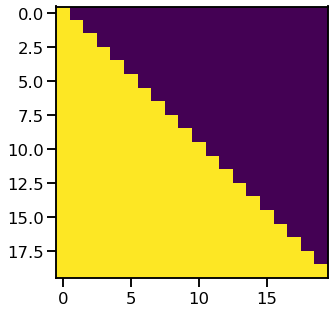

In [17]:
plt.figure(figsize=(5, 5))
plt.imshow(subsequent_mask(20)[0])
None

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    'compute scaled dot product attention'
    d_k = query.size(-1) # 最后一维
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim= -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn